In [59]:
import pandas as pd

import os
import pickle as pkl

from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, KFold, cross_val_predict
from sklearn.metrics import r2_score, explained_variance_score, normalized_mutual_info_score, \
    mutual_info_score, mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from skll.metrics import spearman, pearson 


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 6,6

Custom model implementations and functions are stored in `src/dairyml.py`

In [5]:
from dairyml import PerfectClassifierMeanRegressor, plot_r2, BoundedLasso, BoundedLassoPlusLogReg, plot_coefficients, DummyRegressorCustom

## Import the Data
Load the data from the csv file, and set FoodCode to be the data index

In [6]:
data = pd.read_csv('../data/training_for_GS_122118.csv')
data = data.set_index('FoodCode')

Get the indices of all columns except description and lactose content - these columns are the numerical features that will be used as model input



In [7]:
numerical_features = data.columns[1:-1]
# print(numerical_features)

## Assess correlation of features with target variable

### Spearman's rank correlation coefficient

In [8]:
correlations = pd.DataFrame()
correlations['SRC'] = data[list(numerical_features) + ['lac.per.100g']].corr(method='spearman')['lac.per.100g']

### Mutual Information

In [9]:
for col in numerical_features:
    correlations.loc[col,'MI'] = mutual_info_score(data[col],data['lac.per.100g'])
    correlations.loc[col,'NMI'] = normalized_mutual_info_score(data[col],data['lac.per.100g'])

### Report average values for each correlation measure

In [10]:
# correlations

In [11]:
correlations.abs().mean(axis=0)

SRC    0.204037
MI     3.192658
NMI    0.726827
dtype: float64

In [12]:
# correlations.to_excel('../data/correlations.xlsx')

## Prepare data for modelling
### Standardize the input features
- Use only the numerical features as model input `X`  
- Use sklearn's `StandardScaler` on these features: this standardizes features by removing the mean and scaling to unit variance 
- Convert the output of `StandardScaler` back to a dataframe for convenience

In [31]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(data[numerical_features]),columns=data[numerical_features].columns,index=data.index)
# X.head()

### Remove outliers

`contamination` parameter was hand-tuned based on the appearance of PCA & t-SNE visualizations below, increasing until data points that appeared to be outliers were removed

In [32]:
iso = IsolationForest(contamination=.013)
outliers = iso.fit_predict(X)
print('Outliers removed: {}'.format(sum(outliers == -1)))

Outliers removed: 5


In [33]:
X = X[outliers == 1]

### Use lactose as prediction target `Y`

In [34]:
Y = data['lac.per.100g'][outliers == 1]
# Y.head()

## Distribution of target variable, class imbalance

In [35]:
Y_binary = (Y != 0).replace(True,'lactose').replace(False,'non-lactose')

#### Class absolute numbers

In [14]:
Y_binary.value_counts()

lactose        291
non-lactose     87
Name: lac.per.100g, dtype: int64

#### Class proportions

In [15]:
Y_binary.value_counts().divide(Y_binary.value_counts().sum()).round(2)

lactose        0.77
non-lactose    0.23
Name: lac.per.100g, dtype: float64

#### Distribution of all lactose values

Text(0.5, 1.0, 'Distribution of all lactose values')

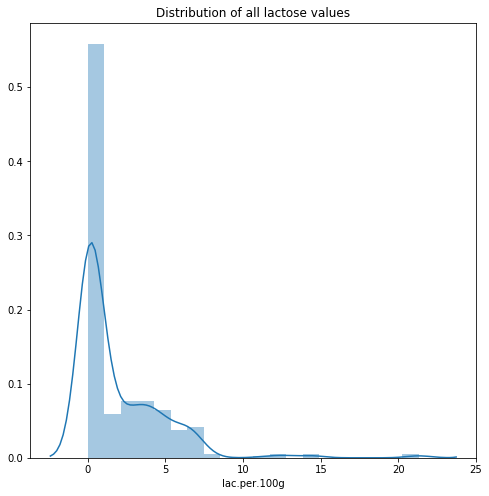

In [120]:
sns.distplot(Y,bins=20)
plt.title("Distribution of all lactose values")

#### Distribution of nonzero lactose values

Text(0.5, 1.0, 'Distribution of nonzero lactose values')

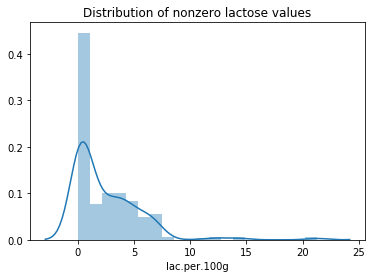

In [17]:
sns.distplot(Y[Y!=0],bins=20)
plt.title("Distribution of nonzero lactose values")

## Visualization: PCA & t-SNE

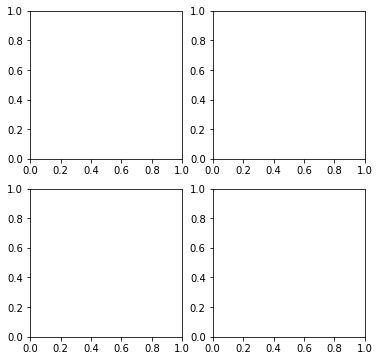

In [36]:
f, axes = plt.subplots(2, 2)

### PCA

Here we use PCA to visualize the features along two axes. Two plots are produced. In the first, the data points are colored by lactose value. In the second, the data points are colored by the logarithm of the lactose values. Since most lactose values are low, with a few high exceptions, coloring by lactose value directly obscures the differences on the lower end of the distribution, so coloring by log lactose attempts to fix that.  

In [37]:
pca = PCA(n_components=2)
pca_results = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2'],index=X.index)

In [38]:
pca_results['lac.per.100g'] = Y
pca_results['log.lac.per.100g'] = np.log(pca_results['lac.per.100g'] + .001)
pca_results['log_nonzero.lac.per.100g'] = np.log(pca_results['lac.per.100g'])
# cmap = cm.get_cmap('Spectral')
ax = pca_results.plot.scatter('PC1','PC2',c='log_nonzero.lac.per.100g',colormap='winter',ax=axes[0,0])
axes[0,0].set_xlabel('PC1')
axes[0,0].set_title('PCA, color by log lactose (nonzero only)')
plt.show()
ax = pca_results.plot.scatter('PC1','PC2',c='log.lac.per.100g',colormap='winter',ax=axes[0,1])
axes[0,1].set_xlabel('PC1')
axes[0,1].set_title('PCA, color by log lactose')

Text(0.5, 1.0, 'PCA, color by log lactose')

### t-SNE

The same plots are created using t-SNE, a different visualization technique.

In [39]:
tsne = TSNE(n_components=2,perplexity=30)
tsne_results = pd.DataFrame(tsne.fit_transform(X),columns=['axis 1','axis 2'],index=X.index)

In [40]:
tsne_results['lac.per.100g'] = Y
tsne_results['log.lac.per.100g'] = np.log(tsne_results['lac.per.100g'] + .001)
tsne_results['log_nonzero.lac.per.100g'] = np.log(tsne_results['lac.per.100g'])
# cmap = cm.get_cmap('Spectral')
ax = tsne_results.plot.scatter('axis 1','axis 2',c='log_nonzero.lac.per.100g',colormap='winter',ax=axes[1,0])
axes[1,0].set_xlabel('axis 1')
axes[1,0].set_title('t-SNE, color by log lactose (nonzero only)')

ax = tsne_results.plot.scatter('axis 1','axis 2',c='log.lac.per.100g',colormap='winter',ax=axes[1,1])
axes[1,1].set_xlabel('axis 1')
axes[1,1].set_title('t-SNE, color by log lactose')

Text(0.5, 1.0, 't-SNE, color by log lactose')

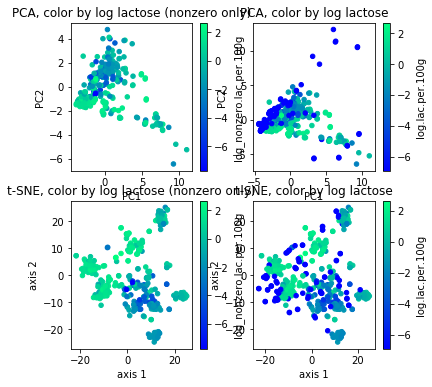

In [41]:
f

### Save preprocessed data to pickle files

In [60]:
data_to_save = [X, Y]
data_dir = '../pkl/data/'
try:
    os.makedirs(data_dir)
except FileExistsError:
    pass

save_string = "data_outliers_removed"

with open(data_dir + save_string, "wb" ) as f:
    pkl.dump(data_to_save,f)

print('saved to {}'.format(data_dir + save_string))

saved to ../pkl/data/data_outliers_removed


## Modelling with Lasso

We will use the below splitter for cross-validation: 10 folds, with shuffling

In [42]:
splitter= KFold(n_splits=10,shuffle=True,random_state=7)

### Baseline Models


In [43]:
scoring = {'r2':make_scorer(r2_score), 
           'SRC':make_scorer(spearman), 
           'PCC':make_scorer(pearson), 
           'MI':make_scorer(mutual_info_score), 
           'MAE':make_scorer(mean_absolute_error)}
# scoring = [r2_score]

In [44]:
overall_results = pd.DataFrame(columns=scoring.keys())

#### Mean

The prediction for each food is the mean of the training lactose values

> The first will just assume that the lactose content in any sample is the mean (or median if you have wild outliers)

In [45]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean_raw_results = cross_validate(dummy_mean,X,Y,cv=splitter,scoring=scoring)
dummy_mean_scores = {}

for score_name in scoring.keys():
#     dummy_mean_scores[score_name] = np.round(np.mean(dummy_mean_raw_results['test_'+score_name]),2)
    overall_results.loc['Dummy Mean',score_name] = np.round(np.mean(dummy_mean_raw_results['test_'+score_name]),2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0,-0,-0,1.94


#### Median of all values

The prediction for each food is the median of the training lactose values
> The first will just assume that the lactose content in any sample is the mean (or median if you have wild outliers)

In [47]:
dummy_median_all = DummyRegressor(strategy='median')
dummy_median_all_raw_results = cross_validate(dummy_median_all,X,Y,cv=splitter,scoring=scoring)
dummy_median_all_scores = {}

for score_name in scoring.keys():
    overall_results.loc['Dummy Median All',score_name] = np.round(np.mean(dummy_median_all_raw_results['test_'+score_name]),2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0,-0,-0,1.94
Dummy Median All,-0.32,0,-0,-0,1.68


#### Median  of nonzero values

The prediction for each food is the median of the _non-zero_ training lactose values
> the first says all have lactose with the median value of the lactose foods as the prediction for all samples

In [48]:
dummy_median_nonzero = DummyRegressorCustom(strategy='median_nonzero',constant=np.median(Y[Y > 0]))
dummy_median_nonzero_raw_results = cross_validate(dummy_median_nonzero,X,Y,cv=splitter,scoring=scoring)
dummy_median_nonzero_scores = {}


for score_name in scoring.keys():
    overall_results.loc['Dummy Median Nonzero',score_name] = np.round(np.mean(dummy_median_nonzero_raw_results['test_'+score_name]),2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0,-0,-0,1.94
Dummy Median All,-0.32,0,-0,-0,1.68
Dummy Median Nonzero,-0.08,0,-0,-0,1.77


#### Perfect classifier plus mean regressor
- This classifier predicts 0 where the true value is 0, or the mean of the training lactose values where the true value is nonzero

- See dairyml.py for implementation

(This class is not compliant with sklearn conventions, this was the easiest implementation I could think of to include perfect classification)

In [49]:
scoring_pcmr = {'r2':r2_score, 
           'SRC':spearman, 
           'PCC':pearson, 
           'MI':mutual_info_score, 
           'MAE':mean_absolute_error}

In [50]:
pcmr = PerfectClassifierMeanRegressor()
pcmr.fit(X,Y)
dummy_pcmr_raw_results = pcmr.cross_val(scoring=scoring_pcmr)
dummy_median_scores = {}

for score_name in scoring.keys():
    overall_results.loc['Perfect Clasif., Mean Regr.',score_name] = np.round(np.mean(dummy_pcmr_raw_results[score_name]),2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0,-0,-0,1.94
Dummy Median All,-0.32,0,-0,-0,1.68
Dummy Median Nonzero,-0.08,0,-0,-0,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53


### Lasso

- Conduct a grid search on the regularization parameter alpha on a log scale between 1e-3 and 1 (np.logspace takes exponents of 10 as arguments)
- For each value of alpha in this range, we perform 10-fold cross validation (CV) on the training data
- Choose the best model based on R^2 score in CV using the `refit` argument of `GridSearchCV`

In [29]:
param_grid = {'alpha': np.logspace(-3, 0, 50)}

refit = 'r2'

search = GridSearchCV(estimator=Lasso(),param_grid=param_grid,scoring=scoring,refit=refit,cv=10)
search.fit(X,Y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223, 0.0256 , 0.02947, 0.03393, 0.03907, 0.04498,...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring={'r2': make_scorer(r2_score), 'SRC': make_scorer(spearman), 'PCC': make_scorer(pearson), 'MI': make_scorer(mutual_info_score), 'MAE': make_scorer(mean_absolute_error)},
       verbose=0)

#### Best value of alpha for Lasso
Print the best value of the regularization parameter, as chosen by 10-fold CV R^2 score above

In [30]:
search.best_estimator_.alpha

0.0517947467923121

#### Lasso test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

In [31]:
search.cv_results_['mean_test_r2'][np.argmax(search.cv_results_['mean_test_'+refit])]

0.36358761906352877

#### Model performance after refitting to the full training set

To take advantage of all the available data, we refit the model to the full training set. (This happens above in `GridSearchCV` automatically). Below we report the "training" R^2 value:

In [32]:
search.score(X,Y)

0.6759509859803272

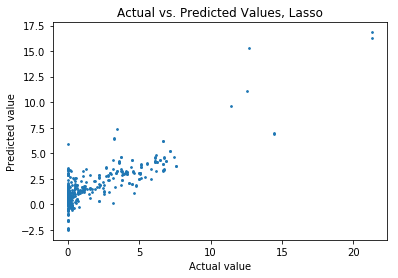

In [33]:
plot_r2(search,'Lasso',X,Y)

### Bounded Lasso
This attempts to fix an obvious issue with the above predictor, that the model predicts negative lactose content for some foods. BoundedLasso wraps sklearn's Lasso model, and "clips" the model output so that negative output values become 0. 

In [34]:
param_grid = {'alpha': np.logspace(-3, 0, 100)}

refit = 'r2'

search = GridSearchCV(estimator=BoundedLasso(),param_grid=param_grid,scoring=scoring,refit=refit,cv=10)
search.fit(X,Y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BoundedLasso(alpha=None), fit_params=None, iid='warn',
       n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00107, ..., 0.9326 , 1.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring={'r2': make_scorer(r2_score), 'SRC': make_scorer(spearman), 'PCC': make_scorer(pearson), 'MI': make_scorer(mutual_info_score), 'MAE': make_scorer(mean_absolute_error)},
       verbose=0)

#### Best value of alpha for Bounded Lasso
Print the best value of the regularization parameter, as chosen by 10-fold CV R^2 score above

In [35]:
search.best_estimator_.alpha

0.04328761281083059

#### Bounded Lasso test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

Performance has improved slightly over the regular Lasso model, from .36 to .38

In [36]:
search.cv_results_['mean_test_r2'][np.argmax(search.cv_results_['mean_test_'+refit])]

0.38489032671670603

#### Bounded Lasso performance after refitting to the full training set

To take advantage of all the available data, we refit the model to the full training set. (This happens above in `GridSearchCV` automatically). Below we report the "training" R^2 value:

In [37]:
search.score(X,Y)

0.7015004716693365

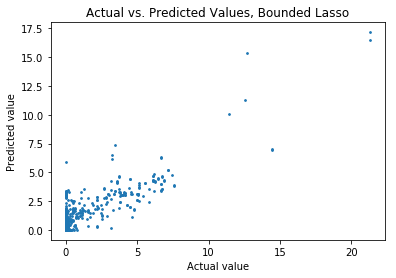

In [38]:
plot_r2(search,'Bounded Lasso',X,Y)

#### Feature importances
Here we plot the non-zero coefficients of the Bounded Lasso model. The magnitude of the coefficient for each feature indicates how much each feature contributes to the overall lactose estimate. We can see that choline, sugar, and potassium contribute positively to the lactose estimate, while fiber, cholesterol, and protein contribute negatively. 

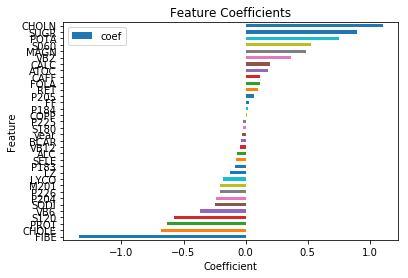

In [39]:
plot_coefficients(search.best_estimator_,X)

#### Compare Lasso feature importances to coefficients from PCA

In [40]:
pca_coefs = pd.DataFrame(pca.components_[0],columns=['PC1 coefficients'],index=numerical_features)

Text(0.5, 1.0, 'PC1 coefficients')

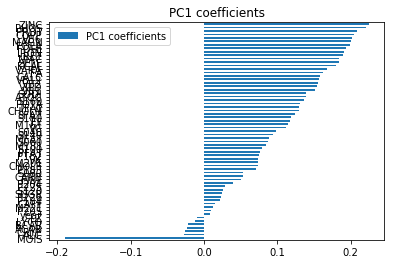

In [41]:
axs = pca_coefs.sort_values('PC1 coefficients').plot.barh()
axs.set_title('PC1 coefficients')

In [42]:
bounded_lasso_coefs = pd.DataFrame(search.best_estimator_.get_coef(),columns=['bounded lasso coefs'],index=numerical_features)
coefs_compare = pd.concat([pca_coefs, bounded_lasso_coefs],axis=1)
coefs_compare.corr(method='spearman')

,PC1 coefficients,bounded lasso coefs
PC1 coefficients,1.000000,0.223738
bounded lasso coefs,0.223738,1.000000


### Bounded Lasso plus Classifier
- Add a binary classifier to the model to predict whether a food is zero or non-zero lactose. 
- In the case that the classifier predicts 0 lactose, the overall model output is 0. 
- In the case that the classifier predicts non-zero, the output from the bounded lasso model is used

#### Evaluate the classifier by itself

In [51]:
Y_binary = Y != 0

param_grid_LR = {'C': np.logspace(-4, 4, 30)}

search_LR = GridSearchCV(estimator=LogisticRegression(solver='lbfgs',max_iter=2000),param_grid=param_grid_LR,scoring=('accuracy','recall'),refit='accuracy',cv=10)
search_LR.fit(X,Y_binary)

# param_grid_SVC = {'C': np.logspace(-4, 4, 30)}
# search_SVC = GridSearchCV(estimator=SVC(kernel='rbf'),param_grid=param_grid_SVC,scoring=('accuracy','recall'),refit='accuracy',cv=10)
# search_SVC.fit(X,Y_binary)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-04, 1.88739e-04, 3.56225e-04, 6.72336e-04, 1.26896e-03,
       2.39503e-03, 4.52035e-03, 8.53168e-03, 1.61026e-02, 3.03920e-02,
       5.73615e-02, 1.08264e-01, 2.04336e-01, 3.85662e-01, 7.27895e-01,
       1.37382e+00, 2.59294e+00, 4.89390e+00, 9.23671e+00, 1.74333e+01,
       3.29034e+01, 6.21017e+01, 1.17210e+02, 2.21222e+02, 4.17532e+02,
       7.88046e+02, 1.48735e+03, 2.80722e+03, 5.29832e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=('accuracy', 'recall'),
       verbose=0)

#### Classifier accuracy
The classifier achieves 89% accuracy in predicting 0 vs non-zero lactose.

In [52]:
search_LR.best_score_

0.8873994638069705

### Evaluate the Bounded Lasso + Classifier Model

In [53]:
param_grid = {'alpha': np.logspace(-3, -1, 10), 'C': np.logspace(-4, 4, 10)}
refit='r2'
search = GridSearchCV(estimator=BoundedLassoPlusLogReg(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
search.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=BoundedLassoPlusLogReg(C=None, alpha=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00167, 0.00278, 0.00464, 0.00774, 0.01292, 0.02154,
       0.03594, 0.05995, 0.1    ]), 'C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring={'r2': make_scorer(r2_score), 'SRC': make_scorer(spearman), 'PCC': make_scorer(pearson), 'MI': make_scorer(mutual_info_score), 'MAE': make_scorer(mean_absolute_error)},
       verbose=0)

#### Plot actual vs predicted results

In [54]:
y_pred = cross_val_predict(search.best_estimator_,X,Y,cv=splitter)

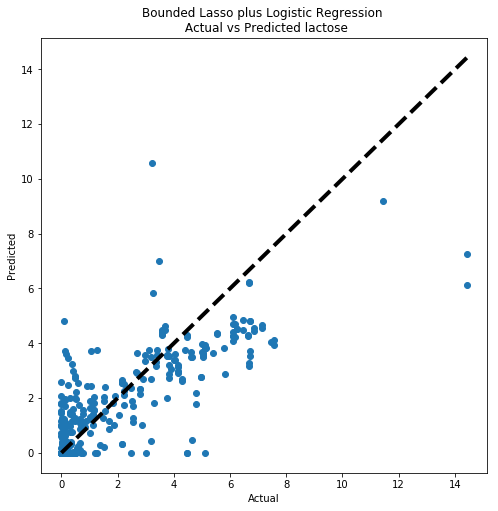

In [55]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, y_pred)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Bounded Lasso plus Logistic Regression \n Actual vs Predicted lactose')
plt.show()

In [56]:
search.best_estimator_.get_params()

{'C': 10000.0, 'alpha': 0.021544346900318832}

#### Model test performance

In [57]:
for score_name in scoring.keys():
    overall_results.loc['Bounded Lasso + LogReg',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0,-0,-0,1.94
Dummy Median All,-0.32,0,-0,-0,1.68
Dummy Median Nonzero,-0.08,0,-0,-0,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Bounded Lasso + LogReg,0.64,0.8,0.82,2.64,0.86
